# Named Entity Recognition (NER) Training Example

This notebook demonstrates the training and evaluation of a Named Entity Recognition (NER) model using TensorFlow. The model is configured to identify entities in text using a BiLSTM-CRF architecture.

## Overview
- Data loading and preprocessing
- Dataset creation and analysis
- Model configuration and training
- Evaluation and metrics
- Example predictions

## Setup and Imports

Import required libraries and set up the project environment. This includes:
- Core data science and ML libraries
- TensorFlow for deep learning
- Project-specific modules for NER

In [6]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Add the project root to the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Load configuration
with open(os.path.join(project_root, 'config.json'), 'r') as f:
    config = json.load(f)

# Import project modules
from src.data_processing.data_loader import load_data, preprocess_data, extract_entities
from src.data_processing.dataset import create_ner_dataset, create_tag_lookup_tables
from src.models.ner_model import build_model
from src.training.train import train_model
from src.utils.metrics import compute_ner_metrics, visualize_prediction
from src.predict import NERPredictor

## Data Loading and Preprocessing

Load the NER dataset from the configured path and perform initial preprocessing steps. The data consists of sentences and their corresponding entity tags.

In [7]:
# Load dataset path from config
data_path = os.path.join(project_root, config['data']['dataset_path'].lstrip('./'))

# Load the dataset
data = load_data(data_path)

# Display the first few rows
display(data.head())

# Preprocess the data
preprocessed_data = preprocess_data(data)

# Display the first few rows after preprocessing
display(preprocessed_data.head())

# Display dataset info
print(f"Number of sentences: {len(preprocessed_data)}")
print(f"Sample sentence: {preprocessed_data['Sentence'].iloc[0]}")
print(f"Sample tags: {preprocessed_data['Tag'].iloc[0]}")

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


,Sentence #,Sentence,POS,Tag,Words
0,Sentence: 1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[Thousands, of, demonstrators, have, marched, ..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Families, of, soldiers, killed, in, the, conf..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO...","[They, marched, from, the, Houses, of, Parliam..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Police, put, the, number, of, marchers, at, 1..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,...","[The, protest, comes, on, the, eve, of, the, a..."


Number of sentences: 47955
Sample sentence: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Sample tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O']


## Data Analysis

Analyze the distribution of entity tags in the dataset. This helps understand the class balance and the types of entities we're working with.

Number of unique tags: 17
Unique tags: {'I-ORG', 'B-TIM', 'B-ART', 'B-GEO', 'O', 'I-EVE', 'B-GPE', 'B-EVE', 'I-NAT', 'I-PER', 'I-ART', 'I-TIM', 'B-NAT', 'I-GPE', 'B-PER', 'B-ORG', 'I-GEO'}


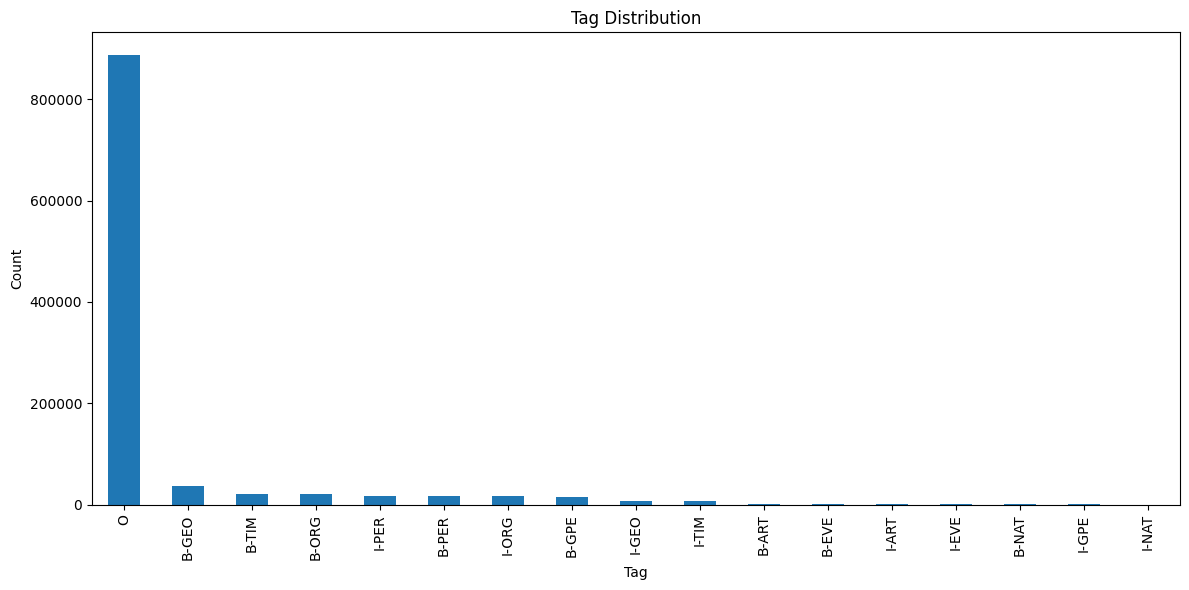

In [8]:
# Count unique tags
all_tags = [tag for tags in preprocessed_data['Tag'] for tag in tags]
unique_tags = set(all_tags)
print(f"Number of unique tags: {len(unique_tags)}")
print(f"Unique tags: {unique_tags}")

# Show tag distribution
tag_counts = pd.Series(all_tags).value_counts()
plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar')
plt.title('Tag Distribution')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Dataset Creation

Create TensorFlow datasets for training, validation, and testing. The data is split according to the ratios specified in the configuration file.

In [12]:
# Get parameters from config
batch_size = config['train']['batch_size']
max_seq_length = config['train']['max_sequence_length']

# Create datasets
# Unpack all returned values; use _ for any you don't need
train_dataset, val_dataset, test_dataset, word_vocab, tag_vocab, *rest = create_ner_dataset(
    preprocessed_data, 
    batch_size=batch_size,
    max_seq_length=max_seq_length,
    val_split=config['train']['validation_split'],
    test_split=config['train']['test_split']
)

# Get tag mappings
idx2tag, tag2idx = create_tag_lookup_tables(tag_vocab)

print(f"Vocabulary size: {len(word_vocab)}")
print(f"Number of tags: {len(tag_vocab)}")

Vocabulary size: 35171
Number of tags: 19


## Model Configuration

Set up the NER model using parameters from the configuration file. The model architecture is a BiLSTM-CRF network optimized for sequence labeling.

In [13]:
# Get model parameters from config
model_type = config['model']['model_type']
embedding_dim = config['model']['embedding_dim']
hidden_dim = config['model']['hidden_dim']
dropout_rate = config['model']['dropout_rate']
num_tags = len(tag_vocab) + 1  # +1 for padding

# Enable mixed precision if configured
if config['optimization']['use_mixed_precision']:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Build the model
model = build_model(
    vocab_size=len(word_vocab),
    num_tags=num_tags,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate,
    model_type=model_type
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ word_input          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embeddings     │ (None, None, 100) │  3,517,200 │ word_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_dropout   │ (None, None, 100) │          0 │ word_embeddings[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ word_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_layer_1      │ (None, None, 256) │    234,496 │ embedding_dropou… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1        │ (None, None, 256) │        512 │ bilstm_layer_1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, None, 256) │          0 │ layer_norm_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_layer_2      │ (None, None, 256) │    394,240 │ lstm_dropout_1[0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2        │ (None, None, 256) │        512 │ bilstm_layer_2[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, None, 256) │          0 │ layer_norm_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_connectio… │ (None, None, 256) │          0 │ lstm_dropout_1[0… │
│ (Add)               │                   │            │ lstm_dropout_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, None, 256) │    131,712 │ residual_connect… │
│ (MultiHeadAttentio… │                   │            │ residual_connect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_residual  │ (None, None, 256) │          0 │ residual_connect… │
│ (Add)               │                   │            │ self_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_no… │ (None, None, 256) │        512 │ attention_residu… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_projection   │ (None, None, 128) │     32,896 │ attention_layer_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None, 20)  │      2,580 │ output_projectio… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,314,660 (16.46 MB)

 Trainable params: 4,314,660 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation

Train the model using the prepared datasets and evaluate its performance using standard NER metrics:
- F1 Score
- Precision
- Recall

The training process includes early stopping to prevent overfitting.

In [ ]:
# Get training parameters from config
epochs = config['train']['epochs']
learning_rate = config['train']['learning_rate']
model_dir = os.path.join(project_root, 'models')
log_dir = os.path.join(project_root, config['logging']['log_dir'].lstrip('./'))

# Ensure directories exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Train the model
trained_model = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=epochs,
    learning_rate=learning_rate,
    model_dir=model_dir,
    log_dir=log_dir,
    early_stopping_patience=config['train']['early_stopping_patience']
)

# Compute metrics on the test set
metrics = compute_ner_metrics(trained_model, test_dataset, tag_vocab)

# Display metrics
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")

# Display entity-level metrics
print("\nEntity-level metrics:")
for entity_type, entity_metrics in metrics['entity_metrics'].items():
    print(f"{entity_type}:")
    print(f"  Precision: {entity_metrics['precision']:.4f}")
    print(f"  Recall: {entity_metrics['recall']:.4f}")
    print(f"  F1-score: {entity_metrics['f1-score']:.4f}")


Epoch 1/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.8754 - loss: 0.5734
Epoch 1: val_loss improved from inf to 0.11620, saving model to c:\Users\tusik\Desktop\bak\ner\models\checkpoints\ner-20250521-205951-01-0.12.keras

Epoch 1: val_loss improved from inf to 0.11620, saving model to c:\Users\tusik\Desktop\bak\ner\models\checkpoints\ner-20250521-205951-01-0.12.keras
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1219s 1s/step - accuracy: 0.8755 - loss: 0.5731 - val_accuracy: 0.9745 - val_loss: 0.1162 - learning_rate: 2.0000e-05
Epoch 2/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1219s 1s/step - accuracy: 0.8755 - loss: 0.5731 - val_accuracy: 0.9745 - val_loss: 0.1162 - learning_rate: 2.0000e-05
Epoch 2/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9740 - loss: 0.1150
Epoch 2: val_loss improved from 0.11620 to 0.08750, saving model to c:\Users\tusik\Desktop\bak\ner\models\checkpoints\ner-20250521-205951-02-0.09.keras

Epoch 2: val_loss improved from 0.11620 to 0.08750, saving mo

KeyboardInterrupt: 

## Example Predictions

Test the trained model on example sentences to demonstrate its entity recognition capabilities. The model will identify entities such as organizations, locations, and person names.

In [16]:
# NOTE: You must define or load 'word_tokenizer' before using it below!
import os

# Find the latest model file
model_dir = '../models'  # Update with your model directory
model_files = [f for f in os.listdir(model_dir) if f.endswith('.keras')]
if not model_files:
    raise FileNotFoundError("No .keras model files found in the models directory")

latest_model = max(model_files, key=lambda x: os.path.getmtime(os.path.join(model_dir, x)))
model_path = os.path.join(model_dir, latest_model)
print(f"Using model: {latest_model}")

# Initialize the predictor
predictor = NERPredictor(
    model_path=model_path,
    word_tokenizer=word_vocab,
    tag_vocab=tag_vocab,
)

# Example sentences for prediction
example_texts = [
    "Apple is looking at buying U.K. startup for $1 billion",
    "Microsoft CEO Satya Nadella announced a new partnership with OpenAI in Seattle",
    "The European Union has imposed new regulations on tech companies based in the United States",
    "Google's DeepMind researchers published a paper in Nature about AI advances"
]

# Make predictions and visualize results
for text in example_texts:
    tokens, predicted_tags, entities = predictor.predict(text)
    print(f"\nText: {text}")
    print("Entities found:")
    for entity in entities:
        print(f"  - {entity['text']} ({entity['type']})")
    
    # Create a visualization of the prediction using colors
    if entities:
        visualize_prediction(tokens, predicted_tags)
    print("-" * 80)

Using model: ner_model_final_20250520-204254.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step

Text: Apple is looking at buying U.K. startup for $1 billion
Entities found:
  - Apple (ORG)
  - U.K. (ORG)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Text: Apple is looking at buying U.K. startup for $1 billion
Entities found:
  - Apple (ORG)
  - U.K. (ORG)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Text: Microsoft CEO Satya Nadella announced a new partnership with OpenAI in Seattle
Entities found:
  - Microsoft (ORG)
  - Satya Nadella (PER)
  - Seattle (GEO)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Text: Microsoft CEO Satya Nadella announced a new partnership with OpenAI in Seattle
Entities found:
  - Microsoft (ORG)
  - Satya 